In [1]:
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import nltk
from __future__ import division
import numpy as np
import pandas as pd
import re
from itertools import groupby
from wordcloud import WordCloud
from nltk.tokenize import TweetTokenizer
import codecs
import math
import json

In [2]:
df = pd.read_csv('data/H115.csv')
twitterNames = df.tw_name
#Adds nodes to the graph
G = nx.DiGraph()   
K = nx.Graph()

for index, row in df.iterrows():
    name = row['tw_name']
    party = row['Party']
    G.add_node(name, party = party)
    K.add_node(name)

In [3]:
import os
num = 0
listFiles = []
for filename in os.listdir('Data/tweets'):
    listFiles.append(filename)

In [4]:
listEdgesWithWeights = []
for twitterer in listFiles:
    file = open("Data/tweets/"+twitterer, "r") 
    txt = file.read() 
    file.close()
    
    retweeted = re.findall("[\n\r].*RT @\s*([^:]*)",txt)
    
    #Checks if the retweets is in the house of representatives and it isn't themselves.
    for rt in retweeted:
        if rt in list(twitterNames):
            if rt != twitterer:
                listEdgesWithWeights.append((twitterer,rt))

In [5]:
#Calculate weights. List is (twittersender, who that has been retweeted, and the weight)
edges = [(key,len(list(group))) for key, group in groupby(listEdgesWithWeights)]

In [6]:
for ii in range(0,len(edges)):
    G.add_edge(edges[ii][0][0], edges[ii][0][1], weight=edges[ii][1])


for ii in range(0,len(edges)):
    K.add_edge(edges[ii][0][0], edges[ii][0][1])


In [7]:
colorNodes = []
for n in G.nodes.iteritems():
    if n[1]["party"] == "Democratic":
        colorNodes.append('r')
    else:
        colorNodes.append('b')
sizeNodes = [el[1] for el in list(G.degree(G.nodes))]

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:06<00:00, 64.44it/s]


('BarnesHut Approximation', ' took ', '0.78', ' seconds')
('Repulsion forces', ' took ', '4.93', ' seconds')
('Gravitational forces', ' took ', '0.02', ' seconds')
('Attraction forces', ' took ', '0.01', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '0.12', ' seconds')


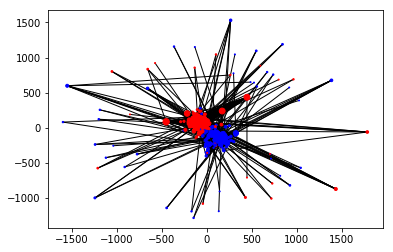

In [8]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=400)
nx.draw_networkx(K, positions, node_color=colorNodes, node_size=sizeNodes, with_labels=False)

The nodes do have different size, however it can be hard to be seen. This is probably due to the force atlas algorithm that stacks many of the big nodes in the center due to gravity.

**Now set the nodes' size proportional to their betweenness centrality. What do you observe?**

In [9]:
LG = nx.betweenness_centrality(G)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:05<00:00, 79.57it/s]


('BarnesHut Approximation', ' took ', '0.58', ' seconds')
('Repulsion forces', ' took ', '3.94', ' seconds')
('Gravitational forces', ' took ', '0.03', ' seconds')
('Attraction forces', ' took ', '0.01', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '0.08', ' seconds')


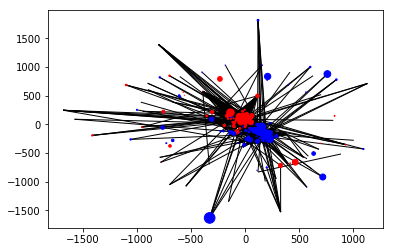

In [10]:
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=400)
nx.draw_networkx(K, positions, node_color=colorNodes, node_size=[n*1000 for n in LG.values()], with_labels=False)

Had to multiply the value with quite a bit, as they changed to significantly smaller size. But the betwenness_centrality actually spread the nodes a bit away from the center.

In [11]:
EG = nx.eigenvector_centrality(G)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:05<00:00, 75.92it/s]


('BarnesHut Approximation', ' took ', '0.52', ' seconds')
('Repulsion forces', ' took ', '4.16', ' seconds')
('Gravitational forces', ' took ', '0.02', ' seconds')
('Attraction forces', ' took ', '0.01', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '0.09', ' seconds')


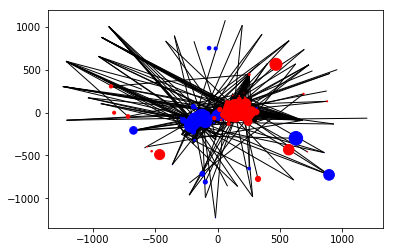

In [12]:
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=400)
nx.draw_networkx(K, positions, node_color=colorNodes, node_size=[n*1000 for n in EG.values()], with_labels=False)

Again multiplication was necessary as size of the nodes became too small. They are still incredibly small even multiplied with 1000. 

**Who are the three nodes with highest degree within each party? And eigenvector centrality? And betweenness centrality?**

In [13]:
import operator

sorted_LG = sorted(LG.items(), key=operator.itemgetter(1))
sorted_EG = sorted(EG.items(), key=operator.itemgetter(1))
dem_LG = []
rep_LG = []
for key,val in sorted_LG:
    if (df[df['tw_name'] == key]['Party'] == "Democratic").bool():
        dem_LG.append((key,val))
    else: 
        rep_LG.append((key,val))
dem_LG.reverse()
rep_LG.reverse()
        
        
dem_EG = []
rep_EG = []
        
for key,val in sorted_EG:
    if (df[df['tw_name'] == key]['Party'] == "Democratic").bool():
        dem_EG.append((key,val))
    else: 
        rep_EG.append((key,val))
dem_EG.reverse()
rep_EG.reverse()        


dem_deg = [(G.degree(n[0]),n[0]) for n in dem_EG]
rep_deg = [(G.degree(n[0]),n[0]) for n in rep_EG]

dem_deg.sort(key=lambda tup: tup[0])
rep_deg.sort(key=lambda tup: tup[0])

dem_deg.reverse()
rep_deg.reverse()


print "Democratic highest betweenness: %s, %s, %s" % (dem_LG[0][0], dem_LG[1][0], dem_LG[2][0])
print "Republican highest betweenness: %s, %s, %s" % (rep_LG[0][0], rep_LG[1][0], rep_LG[2][0])

print "Democratic highest Eigenvector: %s, %s, %s" % (dem_EG[0][0], dem_EG[1][0], dem_EG[2][0])
print "Republican highest Eigenvector: %s, %s, %s" % (rep_EG[0][0], rep_EG[1][0], rep_EG[2][0])

print "Democratic highest Degree: %s, %s, %s" % (dem_deg[0][1], dem_deg[1][1], dem_deg[2][1])
print "Republican highest Degree: %s, %s, %s" % (rep_deg[0][1], rep_deg[1][1], rep_deg[2][1])


Democratic highest betweenness: NancyPelosi, RepDavidEPrice, WhipHoyer
Republican highest betweenness: SpeakerRyan, PatrickMcHenry, SteveScalise
Democratic highest Eigenvector: repmarkpocan, RepCummings, RepRaulGrijalva
Republican highest Eigenvector: RosLehtinen, justinamash, RepSteveStivers
Democratic highest Degree: NancyPelosi, repmarkpocan, WhipHoyer
Republican highest Degree: SpeakerRyan, SteveScalise, GOPLeader


**Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes (e.g. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?**

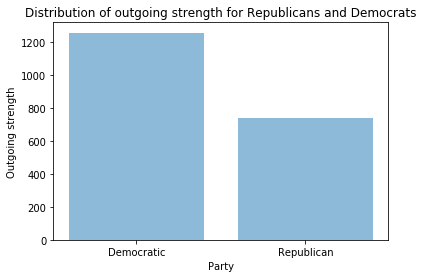

In [14]:
rep_strength = 0
dem_strength = 0

for name,val in dem_EG:
    for edge in G.out_edges(name, data=True):
        dem_strength += edge[2]['weight']
        
for name,val in rep_EG:
    for edge in G.out_edges(name, data=True):
        rep_strength += edge[2]['weight']

        
x = ["Democratic", "Republican"]

plt.bar(x, [dem_strength, rep_strength], align='center', alpha=0.5)
plt.xticks(x)
plt.ylabel('Outgoing strength')
plt.xlabel('Party')
plt.title('Distribution of outgoing strength for Republicans and Democrats')
 
plt.show()

# Part 2: What do republican and democratic members tweet about?

**Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.**

In [15]:
import codecs
import json
for twitterer in listFiles:
    f = codecs.open('Data/tweets/'+twitterer, encoding='utf-8')
    txt = f.read()
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(txt)
    words = [w.lower() for w in tokens]
    patternAd = re.compile("^((?!@).)*$")
    removedAd = [w for w in words if patternAd.match(w) ] #Removed @
    removedRt = [w for w in removedAd if not w == "rt" ] #Removed rt
    patternWeb = re.compile("^(http|https)://") 
    removedWebsites = [w for w in removedRt if not patternWeb.match(w)] #removed websites
    patternNumbers = re.compile("^(?!0*[.,:]?0+$)\d*[.,:]?\d+$")
    removeT = [w for w in removedWebsites if not patternNumbers.match(w) ] #Removed numbers
    removedStopwords = [w.strip() for w in removeT if w.strip() not in nltk.corpus.stopwords.words('english')]
    patternDot = re.compile("^[\W]+$") #Removes dots commas % & etc...
    removedDotsCommas = [w for w in removedStopwords if not patternDot.match(w)]
  
    if (df[df['tw_name'] == twitterer]['Party'] == "Democratic").bool():
        with codecs.open('democrats.txt', 'a',encoding='utf-8') as f:
            f.write("%s\n" % json.dumps(removedDotsCommas))
    else:
        with codecs.open('republicans.txt', 'a',encoding='utf-8') as f:
            f.write("%s\n" % json.dumps(removedDotsCommas))

In [16]:
democratsWords = []
republicanWords = []
with codecs.open('democrats.txt', mode='r', encoding='utf-8') as democrats:
    for line in democrats:
        democratsWords = democratsWords + json.loads(line)

with codecs.open('republicans.txt', mode='r', encoding='utf-8') as republicans:
    for line in republicans:
        republicanWords = republicanWords + json.loads(line)
                

In [38]:
democratsFreq = nltk.FreqDist(democratsWords)
republicanFreq = nltk.FreqDist(republicanWords)

uniqueDemoWords = set(democratsWords)
uniqueRepWords = set(republicanWords)

res = {}
idfsDemo = {}
N = len(democratsWords)
for word in democratsWords:
    try:
        res[word] = res.get(w) + 1
    except:
        res[word] = 1

for word in uniqueDemoWords:
    idfsDemo[word] = math.log(N/float(res[word]))
    
#print idfsDemo

In [37]:
res = {}
idfsRep = {}
N = len(republicanWords)
for word in republicanWords:
    try:
        res[word] = res.get(w) + 1
    except:
        res[word] = 1

for word in uniqueRepWords:
    idfsRep[word] = math.log(N/float(res[word]))
    
#print idfsRep

**Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics from a few weeks ago? Why? Comment on the results.**

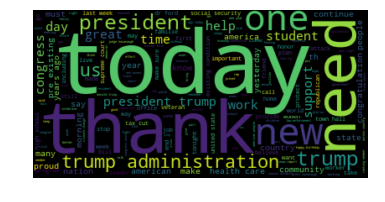

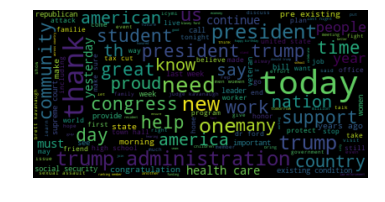

In [19]:
#Democrats wordcloud
from wordcloud import WordCloud
tmp = " ".join(x for x in democratsWords)
wordcloud = WordCloud().generate(tmp)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(tmp)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

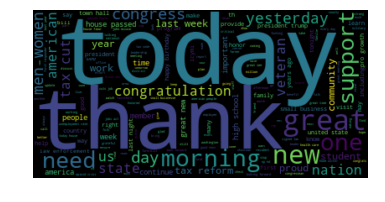

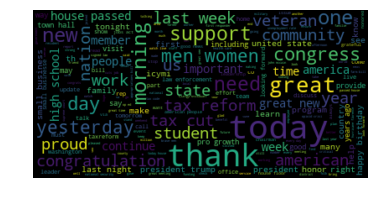

In [20]:
#Republican wordcloud
tmp = " ".join(x for x in republicanWords)
wordcloud = WordCloud().generate(tmp)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(tmp)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The word clouds are quite interesting. As we can clearly see that all the american politicians focuses on "today" aswell as "thank" as it is major for both the republicans and for the democrats. Another funny word that comes to my mind is actually the democrats are mentioning "Trump" so much more than the republicans, most likely because they're focused on pointing out his flaws in politics doing a more offensive way of doing politics since they're focused on the opponent alot in comparison to their own politics. 

# Part 3: Sentiment analysis

**Describe briefly how the list was generated:**
For example twitter data has been used to find all the different words used in the many tweets. This is then evaluated to a happiness score which is simply calculated from human evaluations of the happiness of a set of individual words, and a naive algorithm for scaling up from individual words to texts.

In [21]:
file = codecs.open('Happiness.txt', 'r', encoding='utf-8')
titles = nltk.word_tokenize(file.readline())# To get the titles out

happiness = {}
for line in file:
    split = line.split('\t')
    happiness[split[0]] = split[2]
file.close()

**Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).**

In [22]:
def sentiment(tokens):
    result = 0.0
    tokensl = [x.lower() for x in tokens]
    for word in tokensl:
        if word in happiness.keys():
            data = happiness[word]
            if data != '--' and data != 't':
                result += float(data)
    return result

**Create two lists: one including the tweets written by democratic members, and the other including the tweets written by republican members (in the text files, tweets are separated by newlines).**

In [23]:
democratTweets = []
republicanTweets = []

for twitterer in listFiles:
    file = codecs.open("Data/tweets/"+twitterer, "r", encoding="utf-8") 
    if (df[df['tw_name'] == twitterer]['Party'] == "Democratic").bool():
        for line in file:
            democratTweets.append(line)
            
    else:
        for line in file:
            republicanTweets.append(line)
    file.close()

**Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?**

In [24]:
sentiments = []
tknzr = TweetTokenizer()
for tweet in democratTweets:
        t = tknzr.tokenize(tweet)
        sentiments.append(sentiment(t))


In [25]:
sentimentsRepublicans = []
tknzr = TweetTokenizer()
for tweet in republicanTweets:
        t = tknzr.tokenize(tweet)
        sentimentsRepublicans.append(sentiment(t))

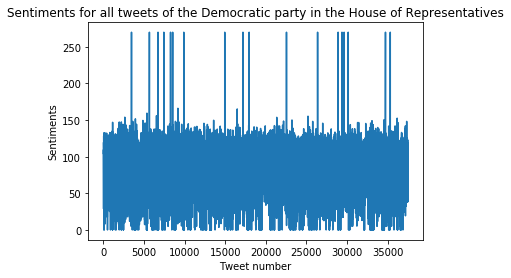

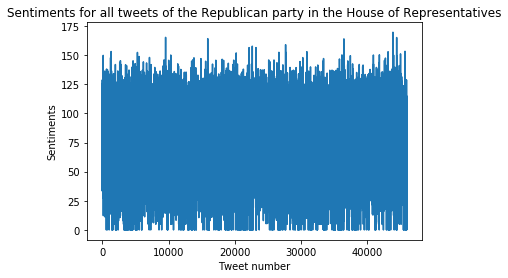

In [26]:
xdem = range(0,len(sentiments))
xrep = range(0,len(sentimentsRepublicans))

plt.plot(xdem, sentiments)
#plt.xticks(xdem)
plt.ylabel('Sentiments')
plt.xlabel('Tweet number')
plt.title('Sentiments for all tweets of the Democratic party in the House of Representatives')
plt.show()

plt.plot(xrep, sentimentsRepublicans)
#plt.xticks(xrep)
plt.ylabel('Sentiments')
plt.xlabel('Tweet number')
plt.title('Sentiments for all tweets of the Republican party in the House of Representatives')
plt.show()

**Compute the average m and standard deviation $\sigma$ of the tweets sentiment (considering tweets by both republican and democrats).**

In [27]:
average = sum(sentiments+sentimentsRepublicans) / len(sentiments+sentimentsRepublicans)
deviation = np.std(sentiments+sentimentsRepublicans)

**Now consider only tweets with sentiment lower than m-2$\sigma$. We will refer to them as negative tweets. Build a list containing the negative tweets written by democrats, and one for republicans. Compute the TF-IDF for these two lists (use the same pre-processing steps in Exercise 5). Create a word-cloud for each of them. Comment on the differences between the negative contents posted by republicans and democrats.**

In [28]:
dictdem = dict(zip(xdem, sentiments))
dictrep = dict(zip(xrep,sentimentsRepublicans))

In [29]:
negativeTweetsdem = [(key,val) for (key,val) in dictdem.iteritems() if val < average-2*deviation]
negativeTweetsrep = [(key,val) for (key,val) in dictrep.iteritems() if val < average-2*deviation]

positiveTweetsdem = [(key,val) for (key,val) in dictdem.iteritems() if val > average+2*deviation]
positiveTweetsrep = [(key,val) for (key,val) in dictrep.iteritems() if val > average+2*deviation]

In [30]:
def tokenize(txt):
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(txt)
    words = [w.lower() for w in tokens]
    patternAd = re.compile("^((?!@).)*$")
    removedAd = [w for w in words if patternAd.match(w) ] #Removed @
    removedRt = [w for w in removedAd if not w == "rt" ] #Removed rt
    patternWeb = re.compile("^(http|https)://") 
    removedWebsites = [w for w in removedRt if not patternWeb.match(w)] #removed websites
    patternNumbers = re.compile("^(?!0*[.,:]?0+$)\d*[.,:]?\d+$")
    removeT = [w for w in removedWebsites if not patternNumbers.match(w) ] #Removed numbers
    removedStopwords = [w.strip() for w in removeT if w.strip() not in nltk.corpus.stopwords.words('english')]
    patternDot = re.compile("^[\W]+$") #Removes dots commas % & etc...
    return [w for w in removedStopwords if not patternDot.match(w)]

In [31]:
tokenizedPositiveTweetsDem = []
tokenizedPositiveTweetsRep = []
for key, value in positiveTweetsdem:
    tokenizedPositiveTweetsDem = tokenizedPositiveTweetsDem + tokenize(democratTweets[key])
for key, value in positiveTweetsrep:
    tokenizedPositiveTweetsRep = tokenizedPositiveTweetsRep + tokenize(republicanTweets[key])

tokenizedNegativeTweetsDem = []
tokenizedNegativeTweetsRep = []    
for key, value in negativeTweetsdem:
    tokenizedNegativeTweetsDem = tokenizedNegativeTweetsDem + tokenize(democratTweets[key])
for key, value in negativeTweetsrep:
    tokenizedNegativeTweetsRep = tokenizedNegativeTweetsRep + tokenize(republicanTweets[key])                

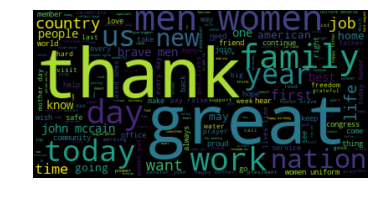

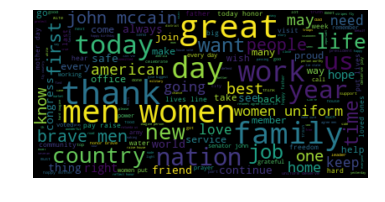

In [32]:
#Republican wordcloud positive
tmp = " ".join(x for x in tokenizedPositiveTweetsRep)
wordcloud = WordCloud().generate(tmp)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(tmp)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

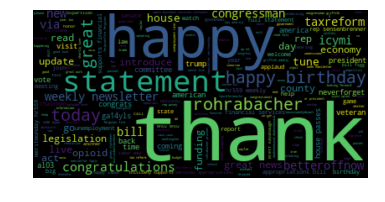

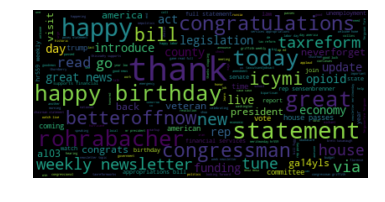

In [33]:
#Republican wordcloud negative
tmp = " ".join(x for x in tokenizedNegativeTweetsRep)
wordcloud = WordCloud().generate(tmp)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(tmp)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

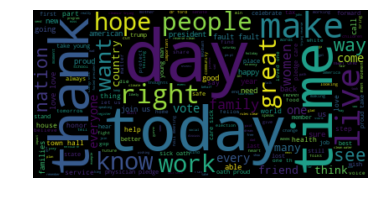

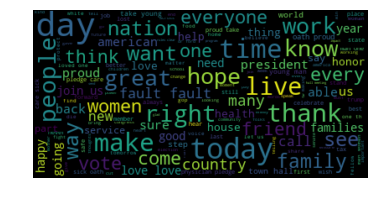

In [34]:
#Democrat wordcloud positive
tmp = " ".join(x for x in tokenizedPositiveTweetsDem)
wordcloud = WordCloud().generate(tmp)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(tmp)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

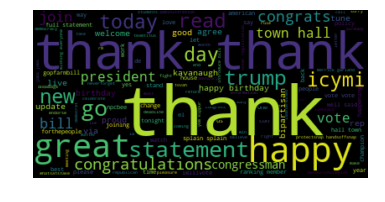

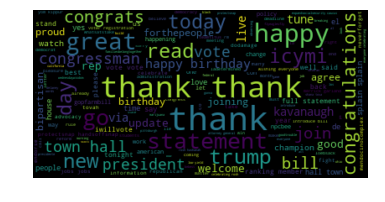

In [35]:
#Democrat wordcloud negative
tmp = " ".join(x for x in tokenizedNegativeTweetsDem)
wordcloud = WordCloud().generate(tmp)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(tmp)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()